In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from detect_outlier import *
from detect_outlier import read_data_without_nomalize
import seaborn as sns



In [2]:
df = read_data_without_nomalize()

In [15]:
from datetime import datetime
import pandas as pd
import numpy as np


def custom_normalization(
    df, column, min_threshold=None, max_threshold=None, zero=True, reverse=False
):
    def transform_score(value, min_val, max_val, reverse):
        if value <= min_val:
            return 850 if reverse else 300
        elif value >= max_val:
            return 300 if reverse else 850
        else:
            scale = (max_val - value) if reverse else (value - min_val)
            return (scale / (max_val - min_val)) * 550 + 300

    df_filtered = df[df[column] != 0] if zero else df
    min_val = (
        df_filtered[column].quantile(min_threshold) if min_threshold is not None else 0
    )
    max_val = df_filtered[column].quantile(max_threshold)

    df[column] = df[column].apply(transform_score, args=(min_val, max_val, reverse))
    return df


def read_data():
    df = pd.read_csv("./data/Lending-Data-Ethereum-Labeled.csv")
    df = df.dropna()
    df = df[df["depositInUSD"] > df["borrowInUSD"]]
    df = df[df["totalAsset"] > 10]
    df.loc[df["borrowInUSD"] < 0.005, "borrowInUSD"] = 0
    df.loc[df["totalAsset"] < 0.005, "totalAsset"] = 0
    df.loc[df["depositInUSD"] < 0.005, "depositInUSD"] = 0
    df.loc[df["balanceInUSD"] < 0.005, "balanceInUSD"] = 0.0
    df["borrow_per_balance"] = np.where(
        df["balanceInUSD"] == 0, 0, df["borrowInUSD"] / df["balanceInUSD"]
    )
    df["borrow_per_deposit"] = np.where(
        df["depositInUSD"] == 0, 0, df["borrowInUSD"] / df["depositInUSD"]
    )
    df["averageTotalAsset"] = (
        df["averageBalance"] + df["depositInUSD"] - df["borrowInUSD"]
    )
    df["deposit_per_asset"] = np.where(
        df["totalAsset"] == 0, 0, df["depositInUSD"] / df["totalAsset"]
    )
    current_timestamp = int(datetime.now().timestamp())
    df["age"] = (current_timestamp - df["createdAt"]).astype(int)

    # Drop column
    df_normalized = (
        df.drop("depositInUSD", axis=1)
        .drop("borrowInUSD", axis=1)
        .drop("balanceInUSD", axis=1)
        .drop("createdAt", axis=1)
        .drop("averageBalance", axis=1)
        # .drop("address", axis=1)
        # .drop("numberOfReputableDapps", axis=1)
    )

    df_normalized = df_normalized[
        ~(
            (df_normalized["frequencyOfTransaction"] == 0)
            & (df_normalized["frequencyMountOfTransaction"] > 0)
        )
    ]
    numeric_columns = df_normalized.select_dtypes(include=['number']).columns
    df_normalized[numeric_columns] = df_normalized[numeric_columns].where(df_normalized[numeric_columns] >= 0)

    # Xóa các hàng có giá trị NaN trong các cột số
    df_normalized = df_normalized.dropna(subset=numeric_columns)
    
    main_label_column = df["1st_label"]
    sub_label_column = df["2nd_label"]

    # totalAsset
    df_normalized = custom_normalization(
        df=df_normalized,
        column="totalAsset",
        zero=False,
        # min_threshold=0.25,
        max_threshold=0.95,
        reverse=False,
    )
    # averageTotalAsset
    df_normalized = custom_normalization(
        df=df_normalized,
        column="averageTotalAsset",
        zero=False,
        # min_threshold=0.25,
        max_threshold=0.95,
        reverse=False,
    )

    # frequencyOfDappTransactions
    df_normalized = custom_normalization(
        df=df_normalized,
        column="frequencyOfDappTransactions",
        zero=True,
        max_threshold=0.95,
        reverse=False,
    )
    # numberOfInteractedDapps
    df_normalized = custom_normalization(
        df=df_normalized,
        column="numberOfInteractedDapps",
        zero=True,
        max_threshold=0.95,
        reverse=False,
    )
    # typesOfInteractedDapps
    df_normalized = custom_normalization(
        df=df_normalized,
        column="typesOfInteractedDapps",
        zero=True,
        max_threshold=0.95,
        reverse=False,
    )
    # numberOfReputableDapps
    df_normalized = custom_normalization(
        df=df_normalized,
        column="numberOfReputableDapps",
        zero=True,
        max_threshold=0.99,
        reverse=False,
    )

    # frequencyMountOfTransaction
    df_normalized = custom_normalization(
        df=df_normalized,
        column="frequencyMountOfTransaction",
        zero=True,
        # min_threshold=0.24,
        max_threshold=0.99,
        reverse=False,
    )
    # frequencyOfTransaction
    df_normalized = custom_normalization(
        df=df_normalized,
        column="frequencyOfTransaction",
        zero=True,
        max_threshold=0.98,
        reverse=False,
    )
    # age
    df_normalized = custom_normalization(
        df=df_normalized,
        column="age",
        zero=False,
        min_threshold=0.05,
        max_threshold=0.95,
        reverse=False,
    )
    # numberOfLiquidation
    df_normalized = custom_normalization(
        df=df_normalized,
        column="numberOfLiquidation",
        zero=True,
        max_threshold=0.98,
        reverse=True,
    )
    # totalValueOfLiquidation
    df_normalized = custom_normalization(
        df=df_normalized,
        column="totalValueOfLiquidation",
        zero=True,
        max_threshold=0.77,
        reverse=True,
    )
    # borrow_per_balance
    df_normalized = custom_normalization(
        df=df_normalized,
        column="borrow_per_balance",
        zero=True,
        # min_threshold=0.36,
        max_threshold=0.95,
        reverse=True,
    )
    # borrow_per_deposit
    df_normalized = custom_normalization(
        df=df_normalized,
        column="borrow_per_deposit",
        zero=True,
        min_threshold=0.05,
        max_threshold=0.95,
        reverse=True,
    )
    # deposit_per_asset
    df_normalized = custom_normalization(
        df=df_normalized,
        column="deposit_per_asset",
        zero=False,
        # min_threshold=0.3,
        max_threshold=0.95,
        reverse=False,
    )

    df_normalized["1st_label"] = main_label_column
    df_normalized["2nd_label"] = sub_label_column
    return df_normalized

In [16]:
df_normalized = read_data()
df_normalized = df_normalized.drop('1st_label', axis=1).drop('2nd_label', axis=1)
df_normalized.to_csv('./data/Lending-Data-Ethereum_Normalized.csv', index=False)

In [3]:
df2 = read_data()

In [4]:
df.columns

Index(['numberOfLiquidation', 'totalValueOfLiquidation',
       'frequencyOfDappTransactions', 'numberOfInteractedDapps',
       'typesOfInteractedDapps', 'numberOfReputableDapps',
       'frequencyOfTransaction', 'totalAsset', 'frequencyMountOfTransaction',
       '1st_label', '2nd_label', 'borrow_per_balance', 'borrow_per_deposit',
       'averageTotalAsset', 'deposit_per_asset', 'age'],
      dtype='object')

In [5]:
from collections import defaultdict

count_number = defaultdict(int)
values = df["totalAsset"].values
for value in values:
    if value == 0:
        count_number["0"] += 1
    elif 0<value<1:
        count_number["0-1"] += 1
    else:
        for i in range(0, 12):
            if 10**i<= value <10**(i+1):
                count_number[f"{i}-{i+1}"] += 1

In [6]:
count_number

defaultdict(int,
            {'3-4': 15578,
             '2-3': 25744,
             '1-2': 34322,
             '4-5': 1724,
             '5-6': 1417,
             '10-11': 1,
             '6-7': 548,
             '7-8': 103,
             '8-9': 24,
             '9-10': 4})

In [7]:
def create_bin(n):
    new_bins = [0]
    for i in range(n):
        for ii in range(1,10):
            new_bins.append(ii*10**i)
    new_bins.append(10**n)
    return new_bins


In [8]:
bins1 = create_bin(1)
bins2 = create_bin(2)
bins3 = create_bin(3)
bins4 = create_bin(4)
bins5 = create_bin(5)
bins6 = create_bin(6)
bins7 = create_bin(7)
bins8 = create_bin(8)
bins9 = create_bin(9)
bins10 = create_bin(10)
bins11 = create_bin(11)
bins12 = create_bin(12)

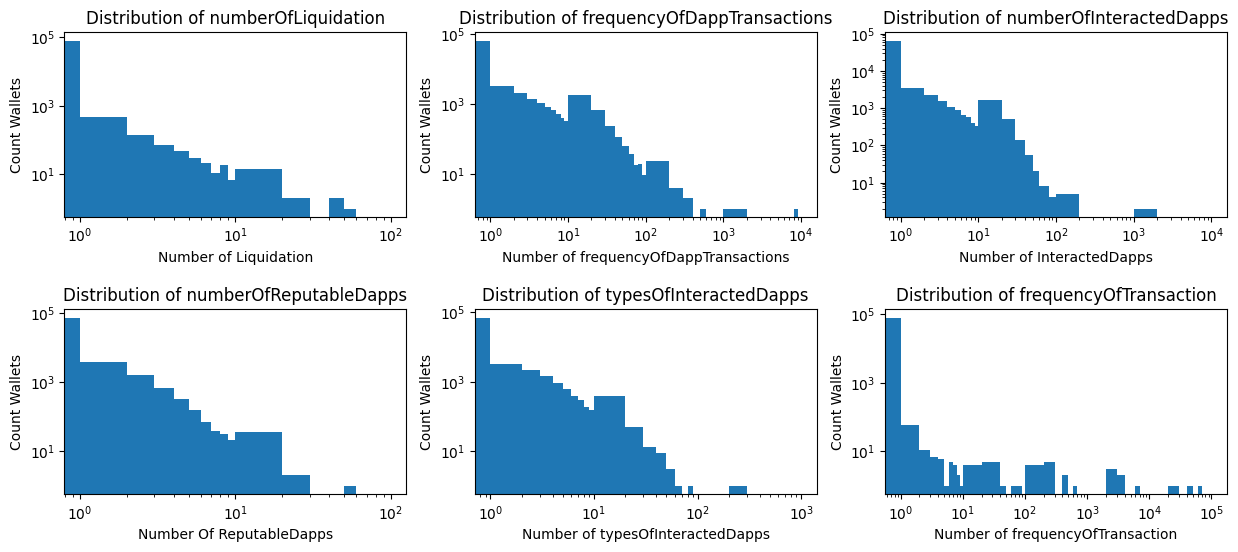

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the bin edges using 64-bit integers
# bins = [0, 1, 10, 50, 100, 500, 1000, 1e4]
# bins2 = [0, 1, 10, 50, 100, 500, 1000, 1e4, 1e5]
# bins3 = [0, 1, 2.5,5, 7.5, 10, 25, 50, 75, 100]
# bins4 = [0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]


# Create a figure with two subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))

# Create the histogram plot for the first graph
ax1.hist(df["numberOfLiquidation"], bins=bins2, log=True)
ax1.set_xlabel("Number of Liquidation")
ax1.set_ylabel("Count Wallets")
ax1.set_title("Distribution of numberOfLiquidation")
ax1.set_xscale("log")  # Use log scale for x-axis

# Create the histogram plot for the second graph
ax2.hist(df["frequencyOfDappTransactions"], bins=bins4, log=True)
ax2.set_xlabel("Number of frequencyOfDappTransactions")
ax2.set_ylabel("Count Wallets")
ax2.set_title("Distribution of frequencyOfDappTransactions")
ax2.set_xscale("log")  # Use log scale for x-axis


ax3.hist(df["numberOfInteractedDapps"], bins=bins4, log=True)
ax3.set_xlabel("Number of InteractedDapps")
ax3.set_ylabel("Count Wallets")
ax3.set_title("Distribution of numberOfInteractedDapps")
ax3.set_xscale("log")  # Use log scale for x-axis

ax4.hist(df["numberOfReputableDapps"], bins=bins2, log=True)
ax4.set_xlabel("Number Of ReputableDapps")
ax4.set_ylabel("Count Wallets")
ax4.set_title("Distribution of numberOfReputableDapps")
ax4.set_xscale("log")  # Use log scale for x-axis

ax5.hist(df["typesOfInteractedDapps"], bins=bins3, log=True)
ax5.set_xlabel("Number of typesOfInteractedDapps")
ax5.set_ylabel("Count Wallets")
ax5.set_title("Distribution of typesOfInteractedDapps")
ax5.set_xscale("log")  # Use log scale for x-axis

ax6.hist(df["frequencyOfTransaction"], bins=bins5, log=True)
ax6.set_xlabel("Number of frequencyOfTransaction")
ax6.set_ylabel("Count Wallets")
ax6.set_title("Distribution of frequencyOfTransaction")
ax6.set_xscale("log")  # Use log scale for x-axis


# ax7.axis("off")
# ax8.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

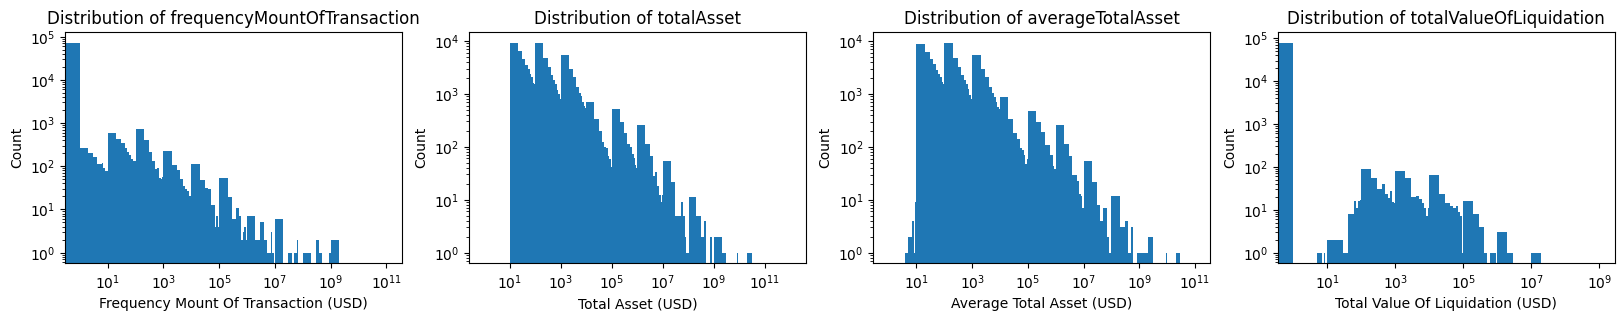

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the bin edges using 64-bit integers
# bins = [0, 1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11]

# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 3))

# Create the histogram plot for the first graph
ax1.hist(df["frequencyMountOfTransaction"], bins=bins11, log=True)
ax1.set_xlabel('Frequency Mount Of Transaction (USD)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of frequencyMountOfTransaction')
ax1.set_xscale('log')  # Use log scale for x-axis

# Create the histogram plot for the second graph
ax2.hist(df["totalAsset"], bins=bins12, log=True)
ax2.set_xlabel('Total Asset (USD)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of totalAsset')
ax2.set_xscale('log')  # Use log scale for x-axis



ax3.hist(df["averageTotalAsset"], bins=bins11, log=True)
ax3.set_xlabel('Average Total Asset (USD)')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of averageTotalAsset')
ax3.set_xscale('log')  # Use log scale for x-axis

# ax4.hist(df["frequencyMountOfTransaction"], bins=bins, log=True)
# ax4.set_xlabel('frequencyMountOfTransaction')
# ax4.set_ylabel('Count')
# ax4.set_title('Distribution of another_column')
# ax4.set_xscale('log')  # Use log scale for x-axis

ax4.hist(df["totalValueOfLiquidation"], bins=bins9, log=True)
ax4.set_xlabel('Total Value Of Liquidation (USD)')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of totalValueOfLiquidation')
ax4.set_xscale('log')  # Use log scale for x-axis

plt.show()

In [11]:
df.columns


Index(['numberOfLiquidation', 'totalValueOfLiquidation',
       'frequencyOfDappTransactions', 'numberOfInteractedDapps',
       'typesOfInteractedDapps', 'numberOfReputableDapps',
       'frequencyOfTransaction', 'totalAsset', 'frequencyMountOfTransaction',
       '1st_label', '2nd_label', 'borrow_per_balance', 'borrow_per_deposit',
       'averageTotalAsset', 'deposit_per_asset', 'age'],
      dtype='object')

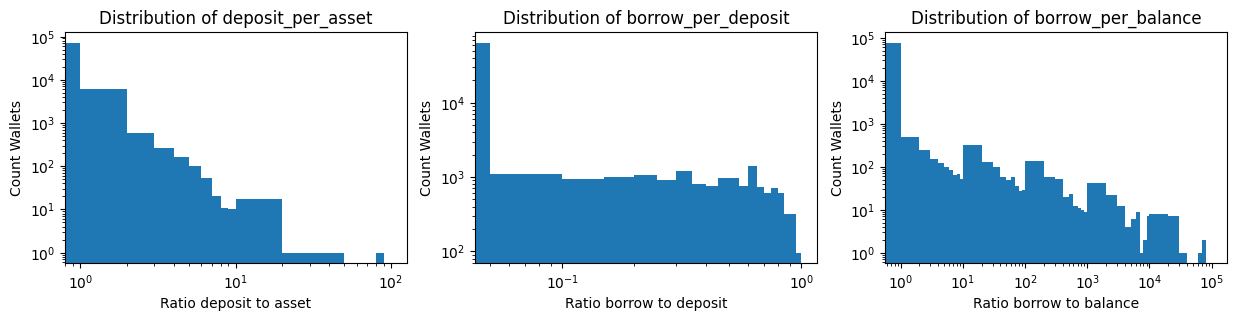

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the bin edges using 64-bit integers
# bins = [0, 1, 10, 50, 100, 500, 1000, 1e4, 1e5]
# bins3 = [0, 1, 10, 25, 50, 75, 100, 250, 500]
# bins_percentage = [x / 100 for x in bins2]
# bins_percentage = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
bins_percentage = [0.05*x for x in range(21)]


# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

# Create the histogram plot for the first graph
ax1.hist(df["deposit_per_asset"], bins=bins2, log=True)
ax1.set_xlabel("Ratio deposit to asset")
ax1.set_ylabel("Count Wallets")
ax1.set_title("Distribution of deposit_per_asset")
ax1.set_xscale("log")  # Use log scale for x-axis

# Create the histogram plot for the second graph
ax2.hist(df["borrow_per_deposit"], bins=bins_percentage, log=True)
ax2.set_xlabel("Ratio borrow to deposit")
ax2.set_ylabel("Count Wallets")
ax2.set_title("Distribution of borrow_per_deposit")
ax2.set_xscale("log")  # Use log scale for x-axis


ax3.hist(df["borrow_per_balance"], bins=bins5, log=True)
ax3.set_xlabel("Ratio borrow to balance")
ax3.set_ylabel("Count Wallets")
ax3.set_title("Distribution of borrow_per_balance")
ax3.set_xscale("log")  # Use log scale for x-axis


# bins_age = [1e6, 2.5e6, 5e6, 1e7, 2.5e7, 5e7, 7.5e7, 1e8, 2.5e8, 5e8, 7.5e8]
# bins_age = [x for x in bins9 if x > 1e6 and x < 7.5e8]
# ax4.hist(df["age"], bins=bins_age, log=True)
# ax4.set_xlabel(" Value of age (seconds)")
# ax4.set_ylabel("Count Wallets")
# ax4.set_title("Distribution of age")
# ax4.set_xscale("log")  # Use log scale for x-axis
plt.show()

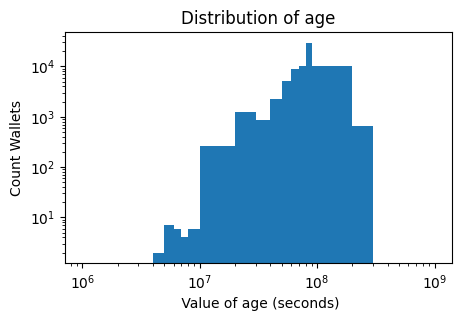

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the bin edges using 64-bit integers
# bins = [0, 1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11]

# Create a figure with two subplots
fig, (ax4) = plt.subplots(1, 1, figsize=(5, 3))
bins_age = [x for x in bins9 if x >= 1e6 and x <= 1e9]
ax4.hist(df["age"], bins=bins_age, log=True)
ax4.set_xlabel(" Value of age (seconds)")
ax4.set_ylabel("Count Wallets")
ax4.set_title("Distribution of age")
ax4.set_xscale("log")  # Use log scale for x-axis
plt.show()


In [14]:
print(max(df["age"]), min(df["age"]))

272455744 4561015


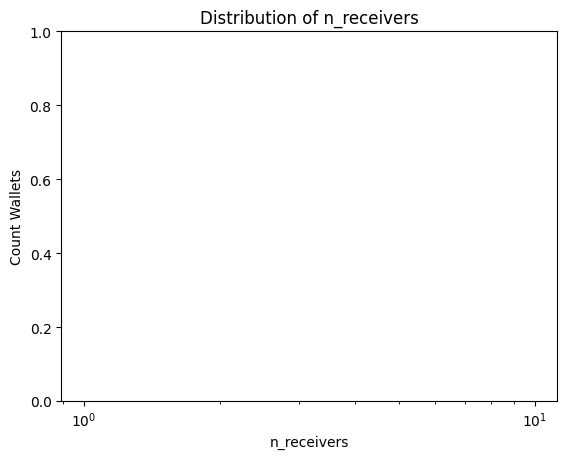

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Define the bin edges using 64-bit integers

# Create the histogram plot
plt
plt.xlabel("n_receivers")
plt.ylabel("Count Wallets")
plt.title("Distribution of n_receivers")
plt.xscale("log")  # Use log scale for x-axis

plt.show()

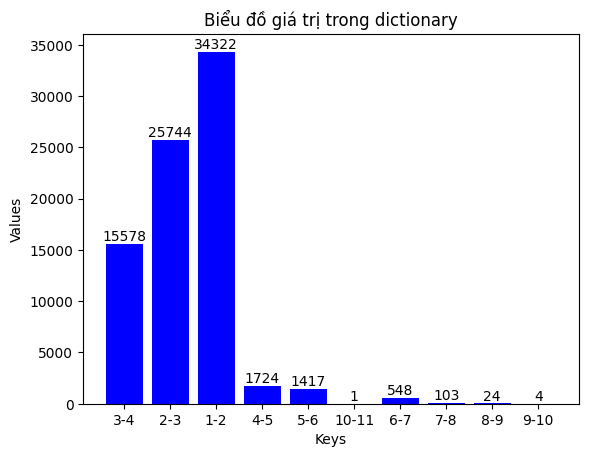

In [16]:
keys = list(count_number.keys())
values = list(count_number.values())

# Vẽ biểu đồ
bars = plt.bar(keys, values, color='blue')
# plt.bar(keys, values)
x_positions = np.arange(len(keys)) * 1.5
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Biểu đồ giá trị trong dictionary')
plt.show()

In [17]:
len(df[(df["numberOfLiquidation"] > 0) & (df["totalValueOfLiquidation"] == 0)])

0

In [18]:
df2.columns

Index(['numberOfLiquidation', 'totalValueOfLiquidation',
       'frequencyOfDappTransactions', 'numberOfInteractedDapps',
       'typesOfInteractedDapps', 'numberOfReputableDapps',
       'frequencyOfTransaction', 'totalAsset', 'frequencyMountOfTransaction',
       '1st_label', '2nd_label', 'borrow_per_balance', 'borrow_per_deposit',
       'averageTotalAsset', 'deposit_per_asset', 'age'],
      dtype='object')

In [19]:
df2 = read_data()

df2.drop("numberOfReputableDapps", axis=1).drop("1st_label", axis=1).drop("2nd_label", axis=1)

,numberOfLiquidation,totalValueOfLiquidation,frequencyOfDappTransactions,numberOfInteractedDapps,typesOfInteractedDapps,frequencyOfTransaction,totalAsset,frequencyMountOfTransaction,borrow_per_balance,borrow_per_deposit,averageTotalAsset,deposit_per_asset,age
6,850.0,850.0,300.0,300.0,300.0,300.0,362.273702,300.0,850.0,850.000000,360.489527,808.675787,300.000000
8,850.0,850.0,300.0,300.0,300.0,300.0,326.337637,300.0,850.0,850.000000,327.087421,344.018910,537.969502
11,850.0,850.0,300.0,300.0,300.0,300.0,302.427540,300.0,850.0,308.136729,302.345658,850.000000,396.966167
14,850.0,850.0,300.0,300.0,300.0,300.0,300.879125,300.0,850.0,850.000000,300.849472,850.000000,591.734466
15,850.0,850.0,300.0,300.0,300.0,300.0,308.911465,300.0,850.0,850.000000,309.075057,346.155909,519.860705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251280,850.0,850.0,300.0,300.0,300.0,300.0,304.934079,300.0,850.0,850.000000,305.119375,320.364318,408.371428
251281,850.0,850.0,300.0,300.0,300.0,300.0,318.297200,300.0,300.0,300.000000,318.562870,850.000000,567.010781
251284,850.0,850.0,300.0,300.0,300.0,300.0,304.616106,300.0,850.0,850.000000,304.736308,363.774221,549.215829
251286,850.0,850.0,300.0,300.0,300.0,300.0,332.212604,300.0,300.0,398.030442,332.362449,850.000000,537.735726


In [20]:
df2['numberOfLiquidation'].nunique()

11

In [7]:
import pandas as pd
df = pd.read_csv("./data/Lending-Data-Ethereum-Labeled.csv")
df = df[df["totalAsset"]>=10]
df = df.dropna()

In [8]:
len(df)

89931

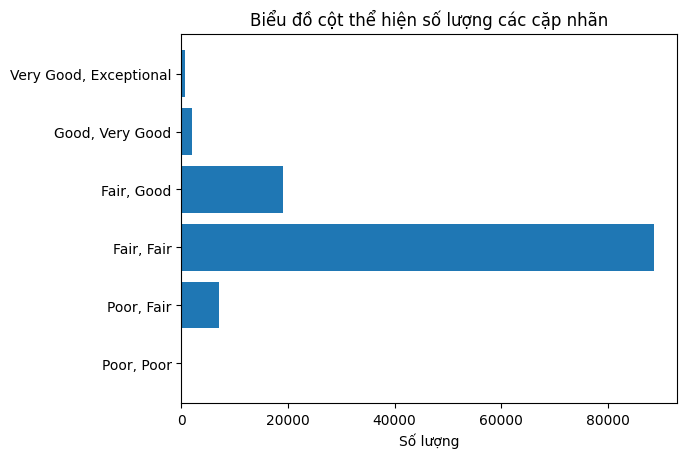

In [9]:
import matplotlib.pyplot as plt

# Dữ liệu mẫu
data = {
    ('Poor', 'Poor'): 89,
    ('Poor', 'Fair'): 7074,
    ('Fair', 'Fair'): 88548,
    ('Fair', 'Good'): 19082,
    ('Good', 'Very Good'): 2085,
    ('Very Good', 'Exceptional'): 714,
}

# Chuyển đổi dữ liệu thành danh sách
labels = list(data.keys())
values = list(data.values())

# Tạo biểu đồ cột
fig, ax = plt.subplots()
ax.barh(range(len(data)), values, tick_label=[f"{a}, {b}" for a, b in labels])
ax.set_xlabel('Số lượng')
ax.set_title('Biểu đồ cột thể hiện số lượng các cặp nhãn')
plt.show()


IndexError: index 12 is out of bounds for axis 0 with size 12

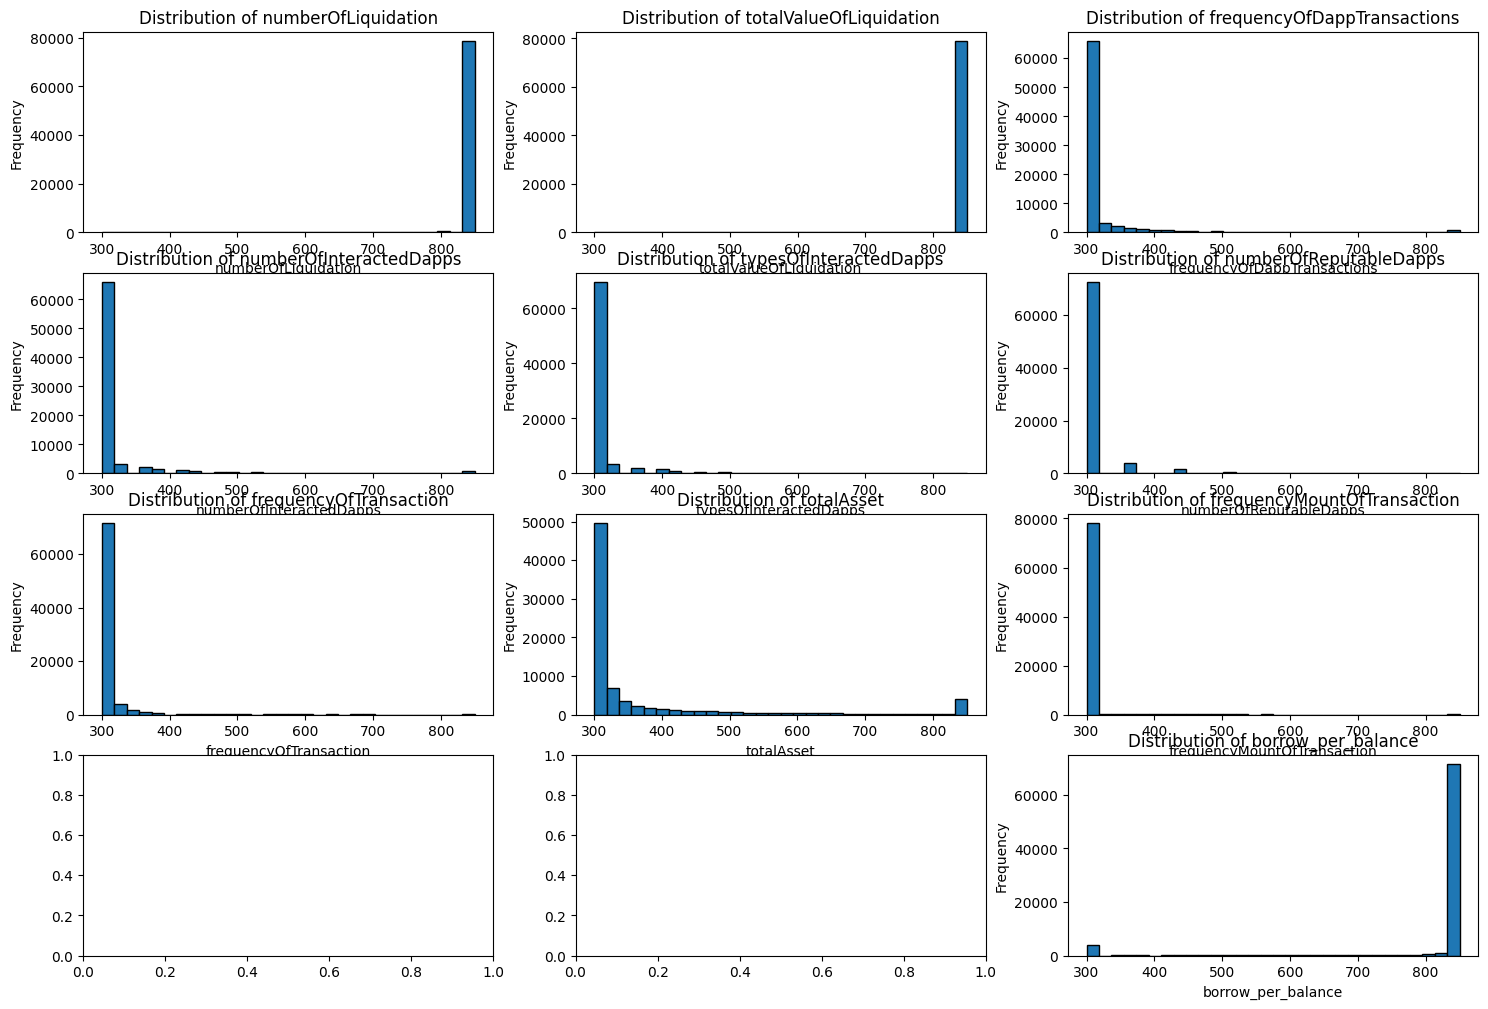

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df2 is your dataframe containing the data

# Create a figure and axes with specified layout
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))  # 4 rows and 3 columns

# Flatten the 2D array of axes into a 1D array
axs = axs.flatten()

# Loop through each column (assuming df2.columns contains the column names)
for i, column in enumerate(df2.columns):
    if column == '1st_label' or column == '2nd_label':
        continue
    values = df2[column].values
    # Create a histogram on the current axis
    axs[i].hist(values, bins=30, edgecolor='black')  # Adjust bins as needed

    # Set title and labels
    axs[i].set_title(f'Distribution of {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')

# Hide any extra subplots
for j in range(len(df2.columns), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
